In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 

# tested in transformers==4.18.0 
import transformers
transformers.__version__
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig

This coding file mainly does the following:

* Calculate the hawkish and dovish score using RoBERTa for each document and store them into a dataframe:
    For each document, we read it as a list of sentences, and we call the RoBERTa to give the classification of hawkish, dovish and neutral for each sentence. Then, we drop the neutal sentences and calculate the hawkish score as the percentage that hawkish sentences occupy the sum of hawkish and dovish sentences:

    Hawkish score of a single doc = (num of hawkish sentences) / (num of hawkish sentences + num of dovish sentences)

    The dovish score is similar:

    Dovish score of a single doc = (num of dovish sentences) / (num of hawkish sentences + num of dovish sentences)

* Download the 2y, 10y US Treasury yield data, calculate the yield spread. Then output the correlation of the yield curve and the hawkishness/dovisheness of the FOMC meetings through time 

## Calculate hawkish & dovish score

Helpful links:

Classification of Hawkish/Dovish:

https://github.com/gtfintechlab/fomc-hawkish-dovish/tree/main

https://huggingface.co/gtfintechlab/FOMC-RoBERTa

Classification of Positive/Negative:

https://github.com/yya518/FinBERT

Label Interpretation:

* LABEL_2: Neutral
* LABEL_1: Hawkish
* LABEL_0: Dovish

The code below bascically loops through files in both the 'fomc_pressconf_cleaned' folder( which contains 36 transcripts of FOMC Press conference) and the 'fomc_pressrelease_cleaned' folder (which contains 40 FOMC press releases). We read each document into a list of sentences and call the RoBERTa to output a dictionary of how many hawkish, dovish or neutral sentences are there in this single document. We then drop the neutral ones, and only keep the dovish and hawkish senetences. 
If there are documents for both the transcripts of Press conference and press releases, then the hawkish score can be calculated as:
hawkish score = num of hawkish sentences in both transcripts and press releases / num of both hawkish and dovish sentences in both transcripts and press releases 



In [19]:
# helper functions 

# read .txt file into a list of sentences 
def read_list_of_sentences(file_path):
    # initiliaze an empty sentences list
    sentences = []

    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            sentences.append(line.strip())
    return sentences 

# store the output results of RoBERTa (list of dict) into a dataframe 
# return the number of hawkish and dovish sentences in that doc
def haw_dov(results):
    df = pd.DataFrame(results)
    df['sentiment'] = df['label'].map({'LABEL_0': 'Dovish','LABEL_1': 'Hawkish','LABEL_2': 'Neutral'})
    
    if 'Hawkish' in df['sentiment'].value_counts():
        hawkish_count = df['sentiment'].value_counts()['Hawkish']
    else:
        hawkish_count = 0 
    if 'Dovish' in df['sentiment'].value_counts():
        dovish_count = df['sentiment'].value_counts()['Dovish'] 
    else:
        dovish_count = 0
    return hawkish_count, dovish_count

In [5]:
# setting up RoBERTa for classifying dovish/hawkish
tokenizer = AutoTokenizer.from_pretrained("gtfintechlab/FOMC-RoBERTa", do_lower_case=True, do_basic_tokenize=True)
model = AutoModelForSequenceClassification.from_pretrained("gtfintechlab/FOMC-RoBERTa", num_labels=3)
config = AutoConfig.from_pretrained("gtfintechlab/FOMC-RoBERTa")

classifier = pipeline('text-classification', model=model, tokenizer=tokenizer, config=config, framework="pt")

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [20]:
base_path = r'E:\NYU\7871 NLP\NLP_HW2'
release_folder = "fomc_pressrelease_cleaned"
trans_folder = "fomc_pressconf_cleaned"

# Initialize 
df = pd.DataFrame(columns=['Date', 'hd_score'])
dict = {}
i = 0

for release_filename in os.listdir('fomc_pressrelease_cleaned'):
    release_date = str(release_filename[8:-4])
    release_path = os.path.join(base_path, release_folder, release_filename)
    sentences_release = read_list_of_sentences(release_path)
    res_release = classifier(sentences_release)
    hawkish_count_release, dovish_count_release = haw_dov(res_release)

    # possible transcript filename 
    trans_filename = 'FOMCpresconf' + release_date + '.txt'
    trans_path = os.path.join(base_path, trans_folder, trans_filename)

    if os.path.exists(trans_path):
        sentences_trans = read_list_of_sentences(trans_path)
        res_trans = classifier(sentences_trans)
        hawkish_count_trans, dovish_count_trans = haw_dov(res_trans)
        total = hawkish_count_release + dovish_count_release + hawkish_count_trans + dovish_count_trans
        hd_score = (hawkish_count_release + hawkish_count_trans) / total
    else:
        print(f"The file '{trans_filename}' does not exist in the directory.")
        total = hawkish_count_release + dovish_count_release
        hd_score = hawkish_count_release / total
    i += 1

    dict[release_date] = hd_score
    print(f'The {i} th: On {release_date}, the hd score is: {hd_score}')


The file 'FOMCpresconf20180131.txt' does not exist in the directory.
The 1 th: On 20180131, the hd score is: 0.4444444444444444
The 2 th: On 20180321, the hd score is: 0.5869565217391305
The file 'FOMCpresconf20180502.txt' does not exist in the directory.
The 3 th: On 20180502, the hd score is: 0.42857142857142855
The 4 th: On 20180613, the hd score is: 0.5833333333333334
The file 'FOMCpresconf20180801.txt' does not exist in the directory.
The 5 th: On 20180801, the hd score is: 0.5714285714285714
The 6 th: On 20180926, the hd score is: 0.6228070175438597
The file 'FOMCpresconf20181108.txt' does not exist in the directory.
The 7 th: On 20181108, the hd score is: 0.6
The 8 th: On 20181219, the hd score is: 0.5568181818181818
The 9 th: On 20190130, the hd score is: 0.5245901639344263
The 10 th: On 20190320, the hd score is: 0.3561643835616438
The 11 th: On 20190501, the hd score is: 0.5189873417721519
The 12 th: On 20190619, the hd score is: 0.4
The 13 th: On 20190731, the hd score is: 0

In [21]:
dict 

{'20180131': 0.4444444444444444,
 '20180321': 0.5869565217391305,
 '20180502': 0.42857142857142855,
 '20180613': 0.5833333333333334,
 '20180801': 0.5714285714285714,
 '20180926': 0.6228070175438597,
 '20181108': 0.6,
 '20181219': 0.5568181818181818,
 '20190130': 0.5245901639344263,
 '20190320': 0.3561643835616438,
 '20190501': 0.5189873417721519,
 '20190619': 0.4,
 '20190731': 0.31868131868131866,
 '20190918': 0.37272727272727274,
 '20191030': 0.38596491228070173,
 '20191211': 0.4536082474226804,
 '20200129': 0.42574257425742573,
 '20200323': 0.16666666666666666,
 '20200429': 0.18253968253968253,
 '20200610': 0.12264150943396226,
 '20200729': 0.17699115044247787,
 '20200916': 0.2074074074074074,
 '20201105': 0.20833333333333334,
 '20201216': 0.2987012987012987,
 '20210127': 0.2892561983471074,
 '20210317': 0.3652173913043478,
 '20210428': 0.40869565217391307,
 '20210616': 0.5757575757575758,
 '20210728': 0.5319148936170213,
 '20210922': 0.5053763440860215,
 '20211103': 0.45588235294117

In [104]:
df = pd.DataFrame(dict.values(), index=dict.keys(), columns=['Hawkish_Degree'])
df.index = pd.to_datetime(df.index)
df['Dovish_Degree'] = 1 - df['Hawkish_Degree']
df

,Hawkish_Degree,Dovish_Degree
2018-01-31,0.444444,0.555556
2018-03-21,0.586957,0.413043
2018-05-02,0.428571,0.571429
2018-06-13,0.583333,0.416667
2018-08-01,0.571429,0.428571
2018-09-26,0.622807,0.377193
2018-11-08,0.600000,0.400000
2018-12-19,0.556818,0.443182
2019-01-30,0.524590,0.475410
2019-03-20,0.356164,0.643836


## Read data
US Treasury 2y: https://fred.stlouisfed.org/series/DGS2

US Treasury 10y: https://fred.stlouisfed.org/series/DGS10

US Treasury 10y - 2y Yield Spread 

In [110]:
# US Treasury 2y yield 
GS_2y = pd.read_csv('DGS2.csv')
GS_2y['DATE'] = pd.to_datetime(GS_2y['DATE'], format='%Y/%m/%d')
GS_2y.dropna(inplace=True)
print(GS_2y.info())
GS_2y.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1304 entries, 0 to 1303
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    1304 non-null   datetime64[ns]
 1   DGS2    1304 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 30.6+ KB
None


,DATE,DGS2
0,2018-01-02,1.92
1,2018-01-03,1.94
2,2018-01-04,1.96
3,2018-01-05,1.96
4,2018-01-08,1.96


In [111]:
# US Treasury 10y yield 
GS_10y = pd.read_csv('DGS10.csv')
GS_10y['DATE'] = pd.to_datetime(GS_10y['DATE'], format='%Y/%m/%d')
GS_10y.dropna(inplace=True)
print(GS_10y.info())
GS_10y.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1304 entries, 0 to 1303
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    1304 non-null   datetime64[ns]
 1   DGS10   1304 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 30.6+ KB
None


,DATE,DGS10
0,2018-01-02,2.46
1,2018-01-03,2.44
2,2018-01-04,2.46
3,2018-01-05,2.47
4,2018-01-08,2.49


In [136]:
# df_yield = pd.concat([GS_2y, GS_10y])
df_yield = pd.merge(GS_2y, GS_10y, on='DATE')
df_yield['DGS2'] = pd.to_numeric(df_yield['DGS2'],errors='coerce')
df_yield['DGS10'] =  pd.to_numeric(df_yield['DGS10'],errors='coerce')
df_yield.dropna(inplace=True)
df_yield

,DATE,DGS2,DGS10
0,2018-01-02,1.92,2.46
1,2018-01-03,1.94,2.44
2,2018-01-04,1.96,2.46
3,2018-01-05,1.96,2.47
4,2018-01-08,1.96,2.49
...,...,...,...
1298,2022-12-23,4.31,3.75
1300,2022-12-27,4.32,3.84
1301,2022-12-28,4.31,3.88
1302,2022-12-29,4.34,3.83


In [113]:
df_yield.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1250 entries, 0 to 1303
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    1250 non-null   datetime64[ns]
 1   DGS2    1250 non-null   float64       
 2   DGS10   1250 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 39.1 KB


In [137]:
df_yield['Yield_Spread'] = df_yield['DGS10'] - df_yield['DGS2']
df_yield['2Y_Chg'] = df_yield['DGS2'] - df_yield['DGS2'].shift(1)
df_yield['10Y_Chg'] = df_yield['DGS10'] - df_yield['DGS10'].shift(1)
df_yield['Yield_Spread_Chg'] = df_yield['Yield_Spread'] - df_yield['Yield_Spread'].shift(1)
df_yield.dropna(inplace=True)
df_yield

,DATE,DGS2,DGS10,Yield_Spread,2Y_Chg,10Y_Chg,Yield_Spread_Chg
1,2018-01-03,1.94,2.44,0.50,0.02,-0.02,-0.04
2,2018-01-04,1.96,2.46,0.50,0.02,0.02,0.00
3,2018-01-05,1.96,2.47,0.51,0.00,0.01,0.01
4,2018-01-08,1.96,2.49,0.53,0.00,0.02,0.02
5,2018-01-09,1.98,2.55,0.57,0.02,0.06,0.04
...,...,...,...,...,...,...,...
1298,2022-12-23,4.31,3.75,-0.56,0.07,0.08,0.01
1300,2022-12-27,4.32,3.84,-0.48,0.01,0.09,0.08
1301,2022-12-28,4.31,3.88,-0.43,-0.01,0.04,0.05
1302,2022-12-29,4.34,3.83,-0.51,0.03,-0.05,-0.08


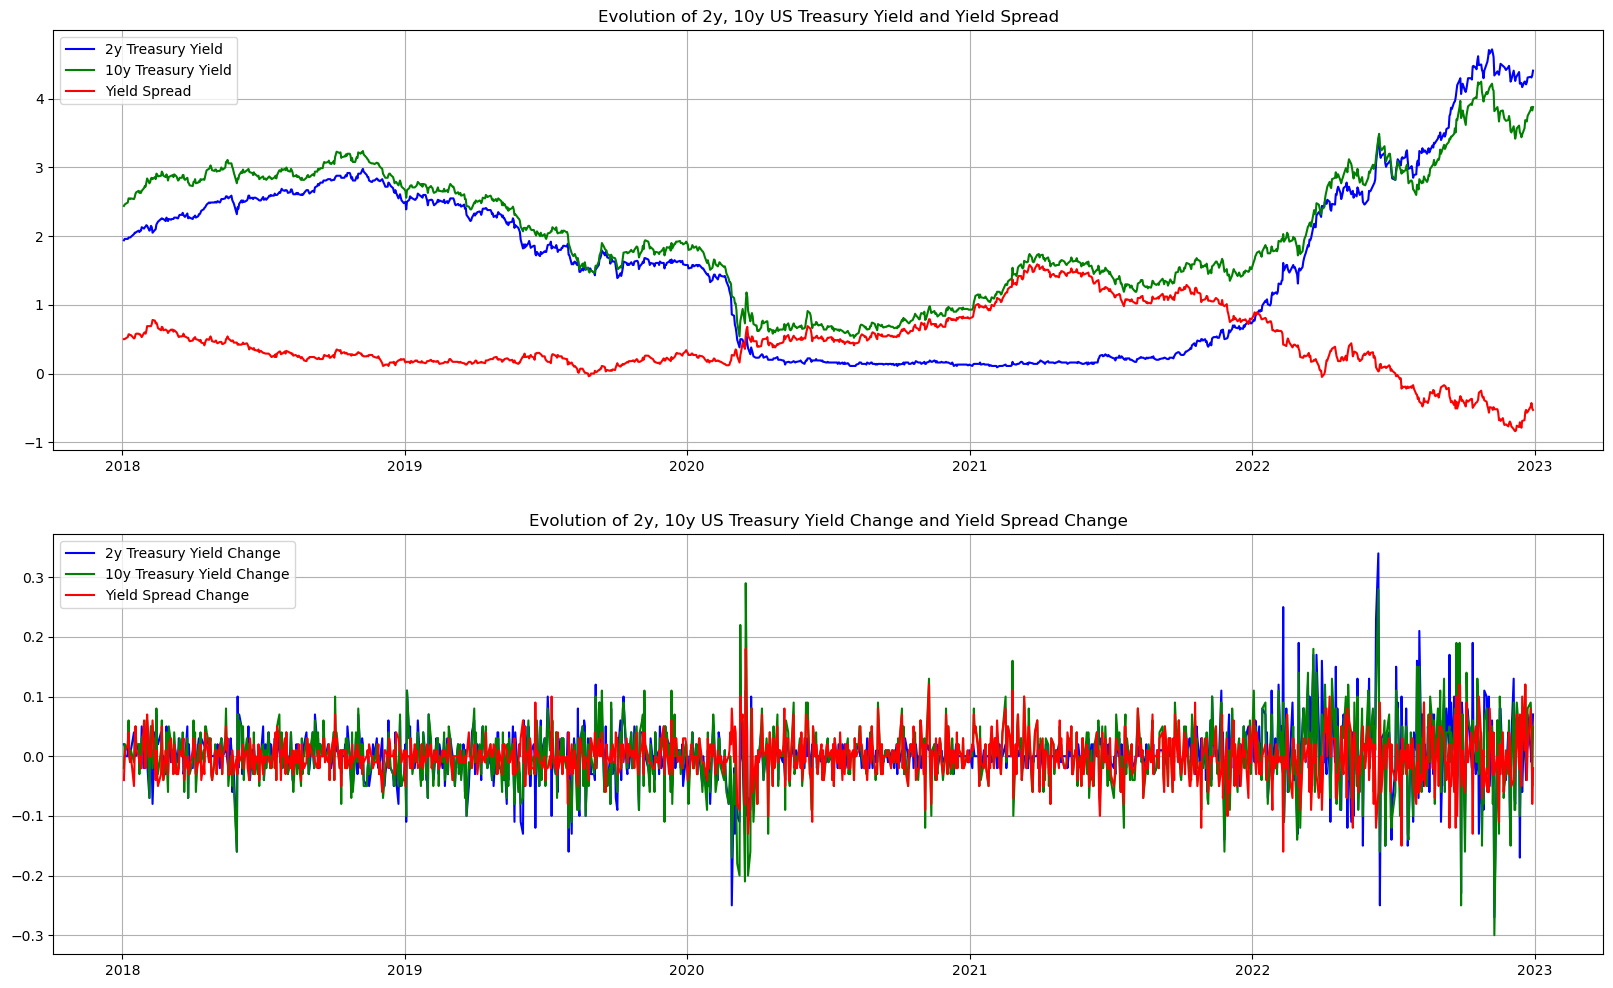

In [123]:
# visualiztion 
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12))

# US Treasury yield 
ax1.plot(df_yield['DATE'], df_yield['DGS2'], linestyle='-', color='b', label='2y Treasury Yield')
ax1.plot(df_yield['DATE'], df_yield['DGS10'], linestyle='-', color='g', label='10y Treasury Yield')
ax1.plot(df_yield['DATE'], df_yield['Yield_Spread'], linestyle='-', color='r', label='Yield Spread')
ax1.legend()
ax1.set_title('Evolution of 2y, 10y US Treasury Yield and Yield Spread')
ax1.grid(True)

# # US Treasury yield change
ax2.plot(df_yield['DATE'], df_yield['2Y_Chg'], linestyle='-', color='b', label='2y Treasury Yield Change')
ax2.plot(df_yield['DATE'], df_yield['10Y_Chg'], linestyle='-', color='g', label='10y Treasury Yield Change')
ax2.plot(df_yield['DATE'], df_yield['Yield_Spread_Chg'], linestyle='-', color='r', label='Yield Spread Change')
ax2.legend()
ax2.set_title('Evolution of 2y, 10y US Treasury Yield Change and Yield Spread Change')
ax2.grid(True)

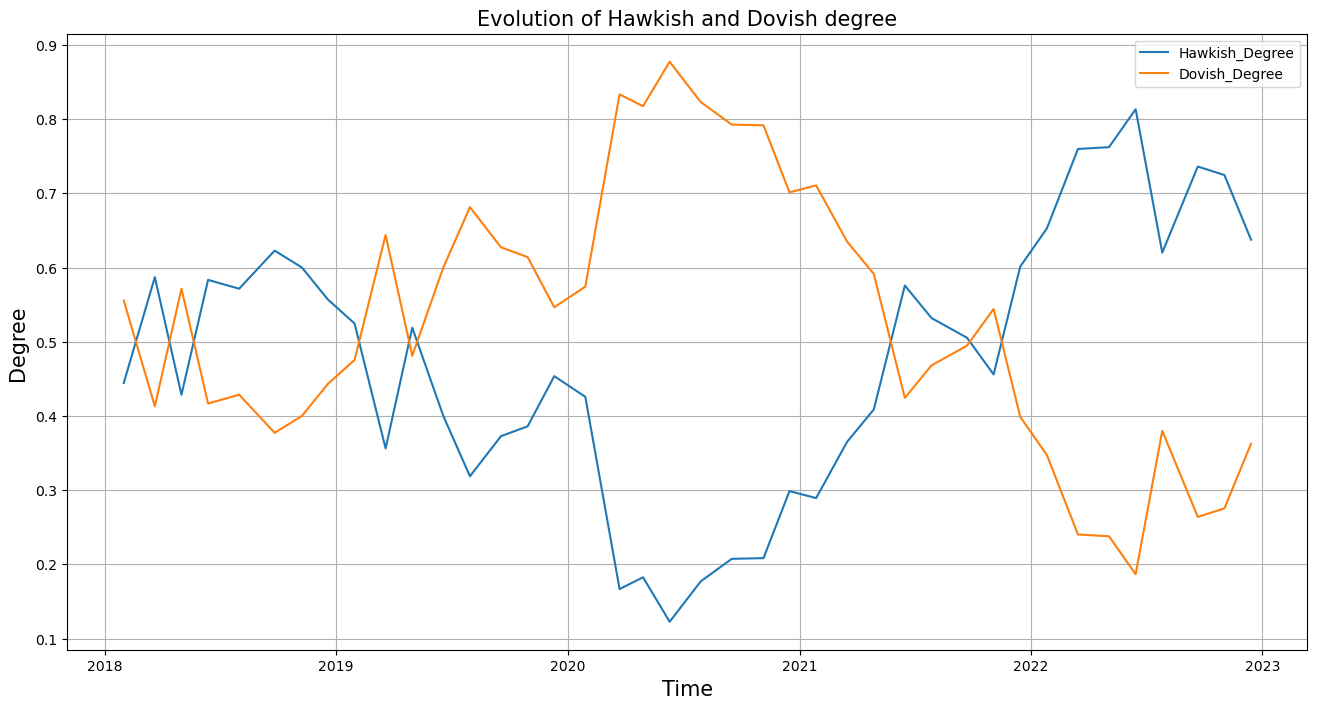

In [124]:
# Visualization of Hawkish and Dovish 
plt.figure(figsize=(16,8))
plt.title("Evolution of Hawkish and Dovish degree",fontsize=15)
plt.plot(df)
plt.xlabel("Time",fontsize=15)
plt.ylabel("Degree ",fontsize=15)
plt.legend(df.columns)
plt.grid(True)
plt.show()

## Correlation

In [134]:
df.head()

,Hawkish_Degree,Dovish_Degree
2018-01-31,0.444444,0.555556
2018-03-21,0.586957,0.413043
2018-05-02,0.428571,0.571429
2018-06-13,0.583333,0.416667
2018-08-01,0.571429,0.428571


In [138]:
df_yield.set_index('DATE', inplace=True)
df_yield.head()

,DGS2,DGS10,Yield_Spread,2Y_Chg,10Y_Chg,Yield_Spread_Chg
DATE,,,,,,
2018-01-03,1.94,2.44,0.50,0.02,-0.02,-0.04
2018-01-04,1.96,2.46,0.50,0.02,0.02,0.00
2018-01-05,1.96,2.47,0.51,0.00,0.01,0.01
2018-01-08,1.96,2.49,0.53,0.00,0.02,0.02
2018-01-09,1.98,2.55,0.57,0.02,0.06,0.04


In [127]:
# merge df and df_yield
df_merged = df.merge(df_yield, left_index=True, right_index=True, how='inner')
df_merged

,Hawkish_Degree,Dovish_Degree,DGS2,DGS10,Yield_Spread,2Y_Chg,10Y_Chg,Yield_Spread_Chg
2018-01-31,0.444444,0.555556,2.14,2.72,0.58,0.01,-0.01,-0.02
2018-03-21,0.586957,0.413043,2.31,2.89,0.58,-0.03,0.00,0.03
2018-05-02,0.428571,0.571429,2.49,2.97,0.48,-0.01,0.00,0.01
2018-06-13,0.583333,0.416667,2.59,2.98,0.39,0.05,0.02,-0.03
2018-08-01,0.571429,0.428571,2.67,3.00,0.33,0.00,0.04,0.04
2018-09-26,0.622807,0.377193,2.83,3.06,0.23,0.00,-0.04,-0.04
2018-11-08,0.600000,0.400000,2.98,3.24,0.26,0.02,0.02,0.00
2018-12-19,0.556818,0.443182,2.63,2.77,0.14,-0.02,-0.05,-0.03
2019-01-30,0.524590,0.475410,2.52,2.70,0.18,-0.04,-0.02,0.02
2019-03-20,0.356164,0.643836,2.40,2.54,0.14,-0.06,-0.07,-0.01


In [128]:
df_merged.corr()

,Hawkish_Degree,Dovish_Degree,DGS2,DGS10,Yield_Spread,2Y_Chg,10Y_Chg,Yield_Spread_Chg
Hawkish_Degree,1.000000,-1.000000,0.695615,0.786296,-0.331907,0.037237,0.151078,0.115687
Dovish_Degree,-1.000000,1.000000,-0.695615,-0.786296,0.331907,-0.037237,-0.151078,-0.115687
DGS2,0.695615,-0.695615,1.000000,0.953146,-0.815875,-0.064703,-0.147703,-0.072321
DGS10,0.786296,-0.786296,0.953146,1.000000,-0.602728,-0.048343,-0.029694,0.036383
Yield_Spread,-0.331907,0.331907,-0.815875,-0.602728,1.000000,0.078267,0.332844,0.260308
2Y_Chg,0.037237,-0.037237,-0.064703,-0.048343,0.078267,1.000000,0.722224,-0.631572
10Y_Chg,0.151078,-0.151078,-0.147703,-0.029694,0.332844,0.722224,1.000000,0.080119
Yield_Spread_Chg,0.115687,-0.115687,-0.072321,0.036383,0.260308,-0.631572,0.080119,1.000000


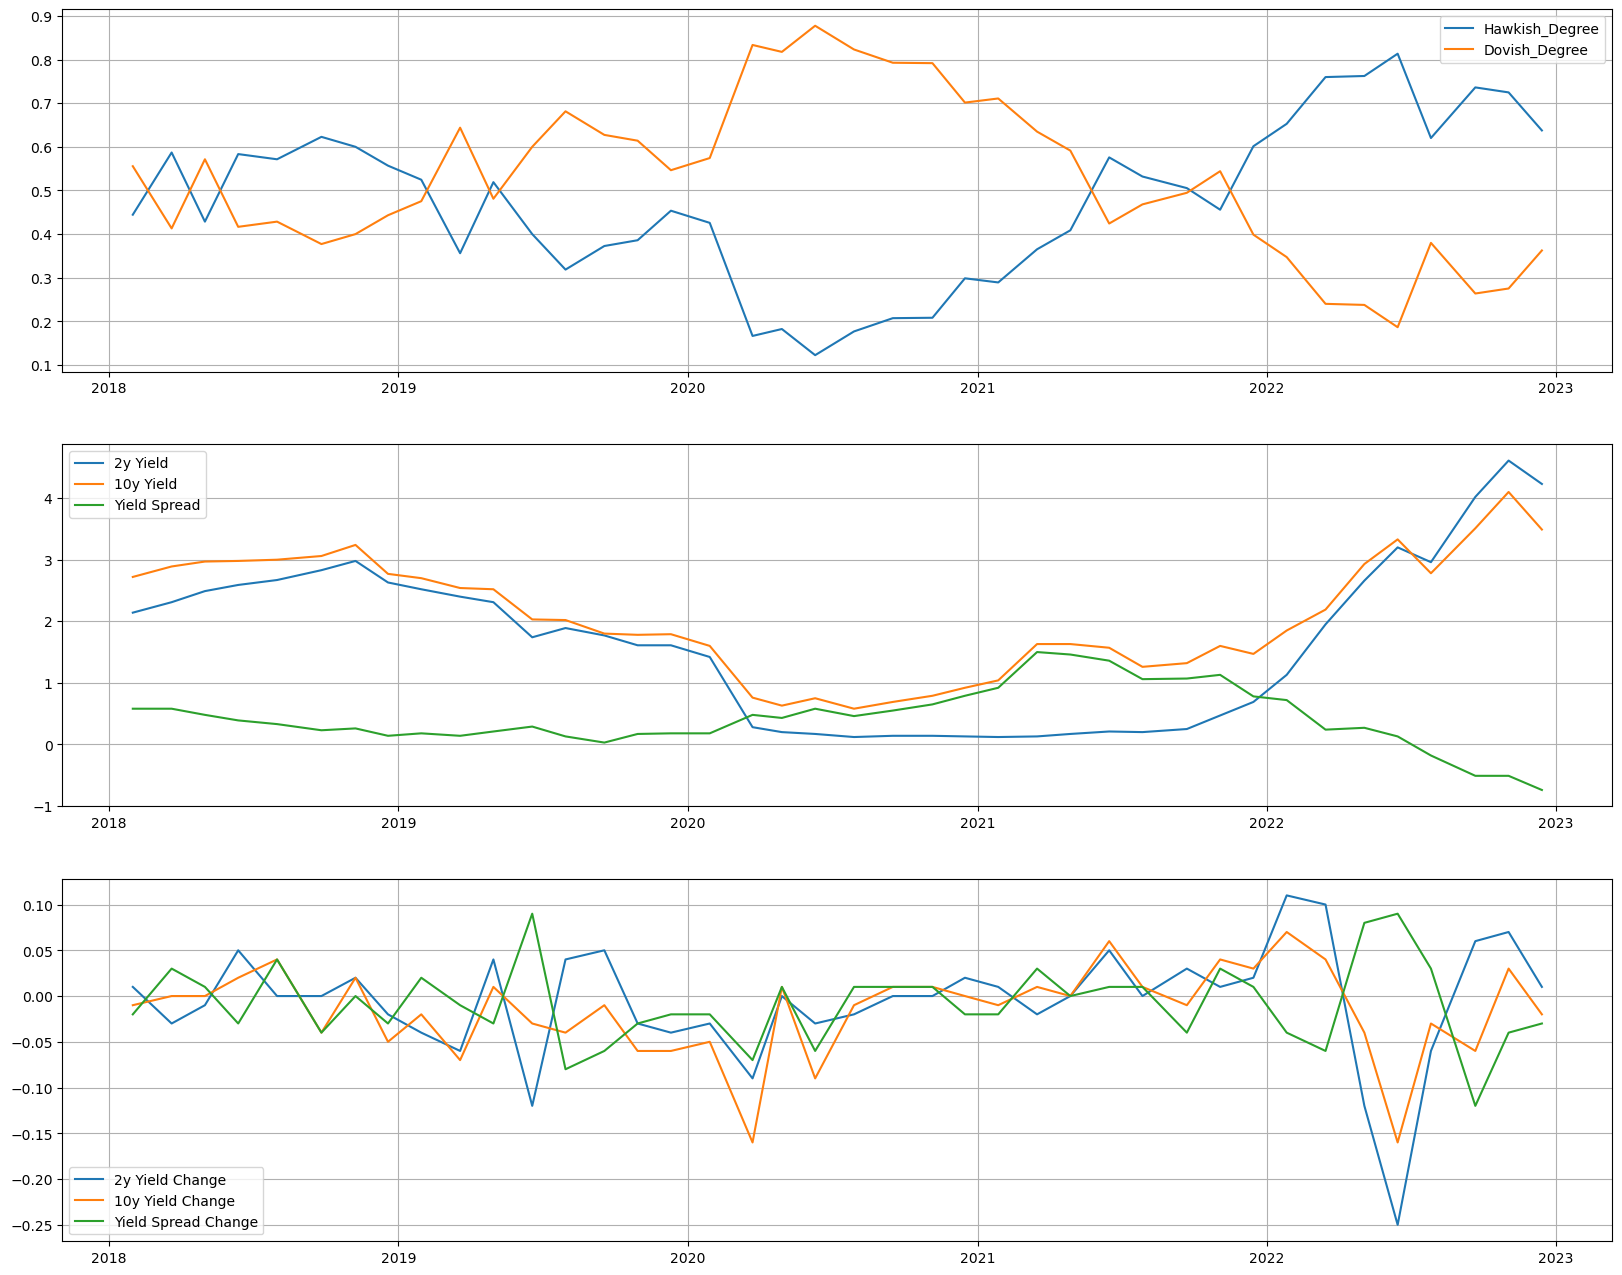

In [133]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(20,16))

ax1.plot(df_merged.index, df_merged['Hawkish_Degree'], label='Hawkish_Degree')
ax1.plot(df_merged.index, df_merged['Dovish_Degree'], label='Dovish_Degree')
ax1.legend()
ax1.grid(True)

ax2.plot(df_merged.index, df_merged['DGS2'], label="2y Yield")
ax2.plot(df_merged.index, df_merged['DGS10'], label="10y Yield")
ax2.plot(df_merged.index, df_merged['Yield_Spread'], label="Yield Spread")
ax2.legend()
ax2.grid(True)

ax3.plot(df_merged.index, df_merged['2Y_Chg'], label="2y Yield Change")
ax3.plot(df_merged.index, df_merged['10Y_Chg'], label="10y Yield Change")
ax3.plot(df_merged.index, df_merged['Yield_Spread_Chg'], label="Yield Spread Change")
ax3.legend()
ax3.grid(True)

From the above plots and correlation table, we can draw the following insights:

* The Dovish degree during the covid period (2020-2021) has increased dramatically, which make sense since the covid strikes economy, interests rates were going down, close to zero, observable from the US Treasury 2y and 10y curve. Therefore, the had FED to adopt a more dovish policy to reboost the economy, and therefore is more tolarable towards inflation (making the interest rate go up).

* Afterwards, during 2022 to 2023, interest rates starts to rise sharply, inflation came. Therefore, the FED's hawkish sentiment rises greatly to control inflation.  